## HydroNet Packing (5 million clusters)

In [1]:
%matplotlib inline

In [2]:
import os
import sys

sys.path.append(os.path.abspath("../"))

In [28]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch_geometric.datasets import HydroNet, QM9
from torch_geometric.nn.pool import radius_graph
from torch_geometric.loader import DataLoader
from torch_geometric.utils import unbatch

from tqdm import tqdm
from torch_geometric.utils import degree

from lpfhp import evaluate_sequence_length_lpfhp
from packing import PackingStrategy

In [4]:
dataset = HydroNet(root="../data/hydronet_packed")
len(dataset)

4464740

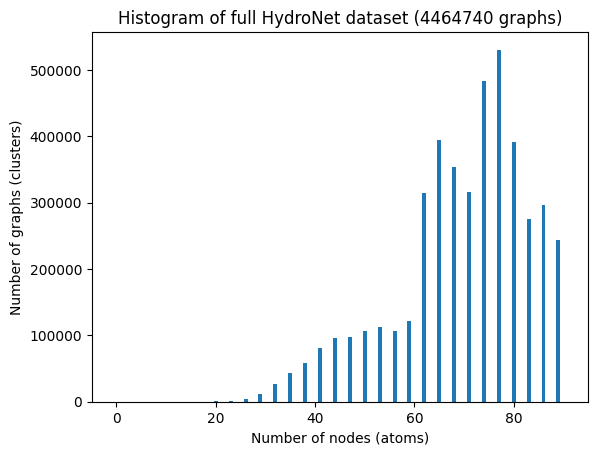

In [5]:
max_nodes = 90
histogram = torch.zeros(max_nodes + 1, dtype=torch.long)

for partition in dataset._partitions:
    num_nodes = 3 * partition.num_clusters
    histogram[num_nodes - 1] = len(partition)

plt.bar(torch.arange(max_nodes + 1).numpy(), histogram.numpy())
plt.xlabel("Number of nodes (atoms)")
plt.ylabel("Number of graphs (clusters)")
plt.title(f"Histogram of full HydroNet dataset ({int(histogram.sum())} graphs)")
plt.show()

pack. depth      # strat. used    # packs    # padding tok.    efficiency (%)    pack.factor    time    max length
-------------  ---------------  ---------  ----------------  ----------------  -------------  ------  ------------
max (5)                     35    2089809           4139148            98.705          2.136   0.000           153
max (6)                     37    2134944           4639971            98.551          2.091   0.000           150
max (5)                     35    2089809           6228957            98.065          2.136   0.000           154
max (6)                     37    2134944           6774915            97.898          2.091   0.000           151
max (5)                     35    2089809           8318766            97.432          2.136   0.000           155
max (5)                     37    2076892           8393523            97.409          2.150   0.000           156
max (6)                     37    2134944           8909859            97.254   

Text(145, 88.70546758569989, 'Best efficiency 98.7 with sequence length 153')

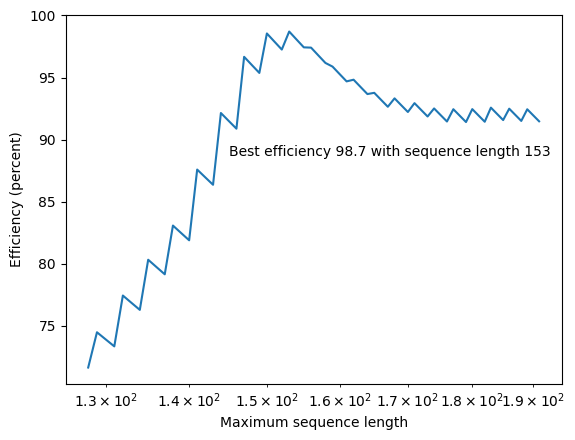

In [6]:
search_range = range(128, 192)
seq_length, efficiency = evaluate_sequence_length_lpfhp(
    histogram.tolist(), search_range
)
plt.plot(seq_length, efficiency)
plt.xscale("log")
plt.xlabel("Maximum sequence length")
plt.ylabel("Efficiency (percent)")
idx = int(torch.tensor(efficiency).argmax())
plt.text(
    seq_length[idx] - 8,
    efficiency[idx] - 10,
    f"Best efficiency {efficiency[idx]:.1f} with sequence length {seq_length[idx]}",
)

In [7]:
np.savez("packing_4.5m.npz", seq_length=seq_length, efficiency=efficiency)

In [8]:
max_num_nodes = 154
max_num_graphs = 5

PackingStrategy.from_histogram(histogram, max_num_nodes, max_num_graphs)

PackingStrategy(packed_len: 2089809, unpacked_len: 4464740, max_num_nodes: 154, max_num_graphs: 6, node_efficiency: 98.1)

## Packing HydroNet Medium (2.7 million clusters)

In [9]:
dataset = HydroNet(root="../data/hydronet_packed", clusters=range(3, 26))
len(dataset)

2726710

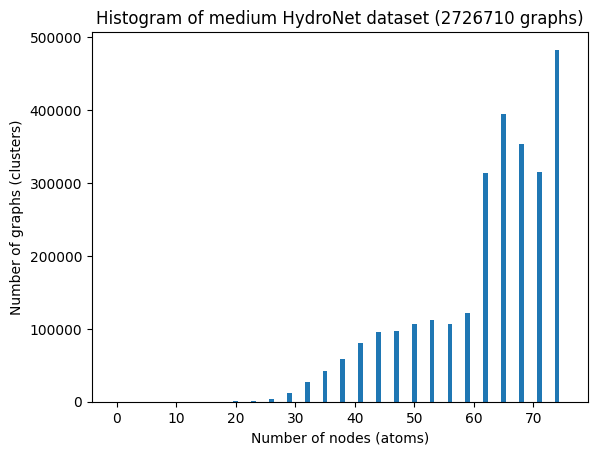

In [10]:
max_nodes = 75
histogram = torch.zeros(max_nodes + 1, dtype=torch.long)

for partition in dataset._partitions:
    num_nodes = 3 * partition.num_clusters
    histogram[num_nodes - 1] = len(partition)

plt.bar(torch.arange(max_nodes + 1).numpy(), histogram.numpy())
plt.xlabel("Number of nodes (atoms)")
plt.ylabel("Number of graphs (clusters)")
plt.title("Histogram of medium HydroNet dataset (2726710 graphs)")
plt.show()

pack. depth      # strat. used    # packs    # padding tok.    efficiency (%)    pack.factor    time    max length
-------------  ---------------  ---------  ----------------  ----------------  -------------  ------  ------------
max (11)                    33     890470           2023665            98.835          3.062   0.001           195
max (7)                     30     879001           2424213            98.607          3.102   0.001           198
max (11)                    33     890470           2914135            98.330          3.062   0.001           196
max (9)                     35     868898           3030513            98.265          3.138   0.001           201
max (5)                     26    1294802           3180285            98.181          2.106   0.000           135
max (7)                     30     879001           3303214            98.112          3.102   0.001           199
max (4)                     27     911401           3371007            98.074   

Text(140, 80, 'Best efficiency 98.8 with sequence length 195')

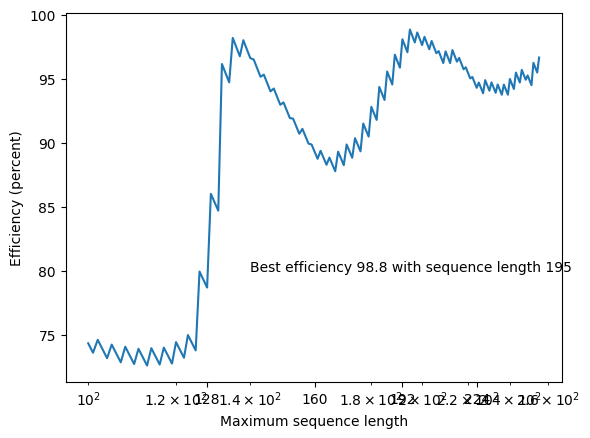

In [11]:
search_range = range(100, 256)
seq_length, efficiency = evaluate_sequence_length_lpfhp(histogram, search_range)

plt.plot(seq_length, efficiency)
plt.xscale("log")
tics = [ii for ii in search_range if ii % 32 == 0]
plt.xticks(tics, tics)
plt.xlabel("Maximum sequence length")
plt.ylabel("Efficiency (percent)")
idx = int(torch.tensor(efficiency).argmax())
plt.text(
    140,
    80,
    f"Best efficiency {efficiency[idx]:.1f} with sequence length {seq_length[idx]}",
)

In [12]:
np.savez("packing_2.7m.npz", seq_length=seq_length, efficiency=efficiency)

In [13]:
PackingStrategy.from_histogram(histogram, max_num_nodes=192, max_num_graphs="max")

PackingStrategy(packed_len: 911401, unpacked_len: 2726710, max_num_nodes: 192, max_num_graphs: 5, node_efficiency: 98.1)

## Packing HydroNet Small (500k clusters)

In [14]:
dataset = HydroNet(root="../data/hydronet_packed", clusters=range(3, 26))
file_path = os.path.join(dataset.processed_dir, "split_00_small.npz")


with np.load(file_path) as split_file:
    train_idx = split_file["train_idx"]
    val_idx = split_file["val_idx"]
    all_idx = np.concatenate([train_idx, val_idx])
    dataset = dataset.index_select(all_idx)

len(dataset)

500000

In [15]:
np.unique(val_idx).shape

(50000,)

100%|██████████| 489/489 [00:05<00:00, 82.09it/s] 


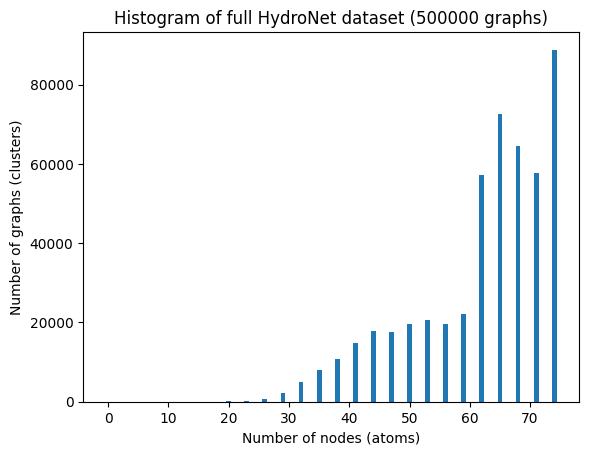

In [16]:
loader = DataLoader(
    dataset,
    batch_size=1024,
    num_workers=32,
    prefetch_factor=16,
    shuffle=False,
    drop_last=False,
)
max_nodes = 75
histogram = torch.zeros(max_nodes, dtype=torch.long)

for batch in tqdm(loader):
    num_nodes = [z.numel() - 1 for z in unbatch(batch.z, batch.batch)]
    num_nodes = torch.tensor(num_nodes)
    ones = torch.ones_like(num_nodes)
    histogram.scatter_add_(dim=0, index=num_nodes, src=ones)

plt.bar(torch.arange(max_nodes).numpy(), histogram.numpy())
plt.xlabel("Number of nodes (atoms)")
plt.ylabel("Number of graphs (clusters)")
plt.title(f"Histogram of full HydroNet dataset ({int(histogram.sum())} graphs)")
plt.show()

pack. depth      # strat. used    # packs    # padding tok.    efficiency (%)    pack.factor    time    max length
-------------  ---------------  ---------  ----------------  ----------------  -------------  ------  ------------
max (11)                    31     163228            368508            98.842          3.063   0.001           195
max (7)                     28     161136            443976            98.608          3.103   0.001           198
max (11)                    31     163228            531736            98.338          3.063   0.001           196
max (8)                     31     159292            556740            98.261          3.139   0.001           201
max (5)                     27     237452            595068            98.144          2.106   0.000           135
max (7)                     28     161136            605112            98.113          3.103   0.001           199
max (4)                     26     167046            611880            98.092   

Text(140, 80, 'Best efficiency 98.8 with sequence length 195')

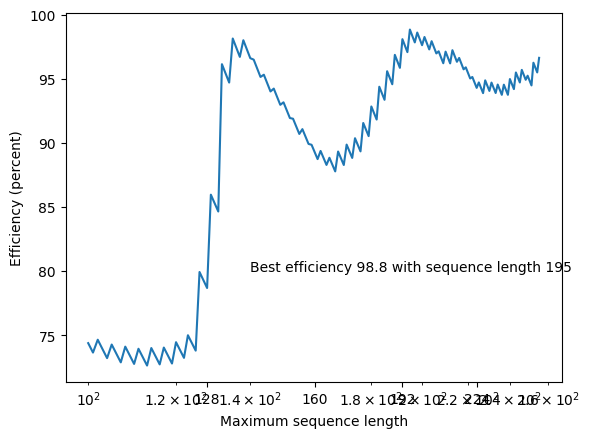

In [17]:
search_range = range(100, 256)
seq_length, efficiency = evaluate_sequence_length_lpfhp(histogram, search_range)

plt.plot(seq_length, efficiency)
plt.xscale("log")
tics = [ii for ii in search_range if ii % 32 == 0]
plt.xticks(tics, tics)
plt.xlabel("Maximum sequence length")
plt.ylabel("Efficiency (percent)")
idx = int(torch.tensor(efficiency).argmax())
plt.text(
    140,
    80,
    f"Best efficiency {efficiency[idx]:.1f} with sequence length {seq_length[idx]}",
)

In [18]:
np.savez("packing_500k.npz", seq_length=seq_length, efficiency=efficiency)

In [19]:
PackingStrategy.from_histogram(histogram, max_num_nodes=192, max_num_graphs="max")

PackingStrategy(packed_len: 167046, unpacked_len: 500000, max_num_nodes: 192, max_num_graphs: 5, node_efficiency: 98.1)

## QM9

100%|██████████| 128/128 [00:03<00:00, 39.10it/s]


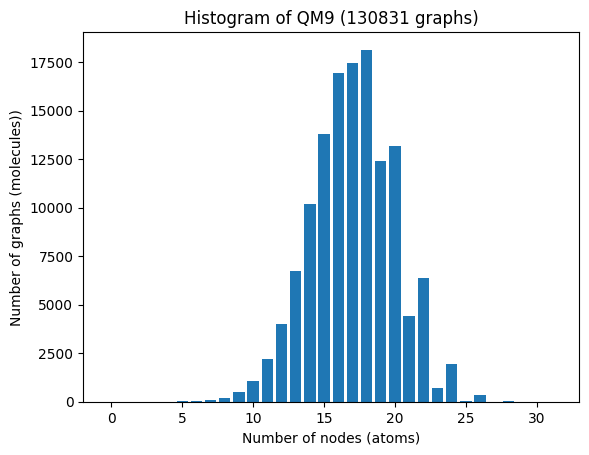

In [31]:
dataset = QM9("../data/qm9")

loader = DataLoader(
    dataset,
    batch_size=1024,
    num_workers=32,
    prefetch_factor=16,
    shuffle=False,
    drop_last=False,
)
max_nodes = 32
histogram = torch.zeros(max_nodes, dtype=torch.long)

for batch in tqdm(loader):
    num_nodes = [z.numel() - 1 for z in unbatch(batch.z, batch.batch)]
    num_nodes = torch.tensor(num_nodes)
    ones = torch.ones_like(num_nodes)
    histogram.scatter_add_(dim=0, index=num_nodes, src=ones)

plt.bar(torch.arange(max_nodes).numpy(), histogram.numpy())
plt.xlabel("Number of nodes (atoms)")
plt.ylabel("Number of graphs (molecules))")
plt.title(f"Histogram of QM9 ({int(histogram.sum())} graphs)")
plt.show()

pack. depth      # strat. used    # packs    # padding tok.    efficiency (%)    pack.factor    time    max length
-------------  ---------------  ---------  ----------------  ----------------  -------------  ------  ------------
max (35)                    41       9398              9086            99.616         13.921   0.001           252
max (34)                    46       9374             12412            99.477         13.957   0.001           253
max (29)                    43      10692             14414            99.393         12.236   0.001           222
max (18)                    42      10755             17645            99.258         12.165   0.001           221
max (32)                    46       9359             17976            99.244         13.979   0.001           254
max (28)                    44      10667             19531            99.179         12.265   0.001           223
max (21)                    39       9483             21023            99.117   

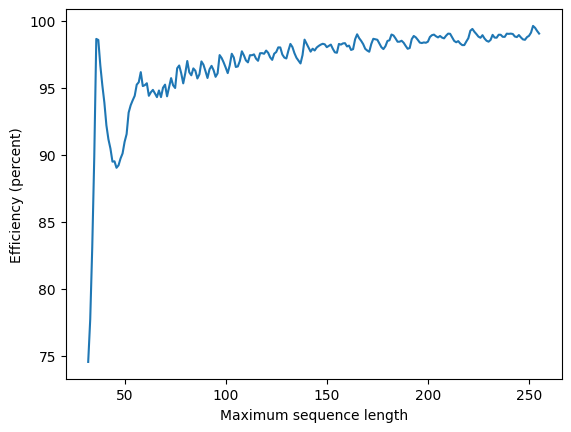

In [36]:
search_range = range(32, 256)
seq_length, efficiency = evaluate_sequence_length_lpfhp(histogram, search_range)

plt.plot(seq_length, efficiency)
# plt.xscale("log")
# tics = [ii for ii in search_range if ii % 32 == 0]
# plt.xticks(tics, tics)
plt.xlabel("Maximum sequence length")
plt.ylabel("Efficiency (percent)")
idx = int(torch.tensor(efficiency).argmax())
# plt.text(140, 80 , f"Best efficiency {efficiency[idx]:.1f} with sequence length {seq_length[idx]}")

In [37]:
np.savez("packing_qm9.npz", seq_length=seq_length, efficiency=efficiency)

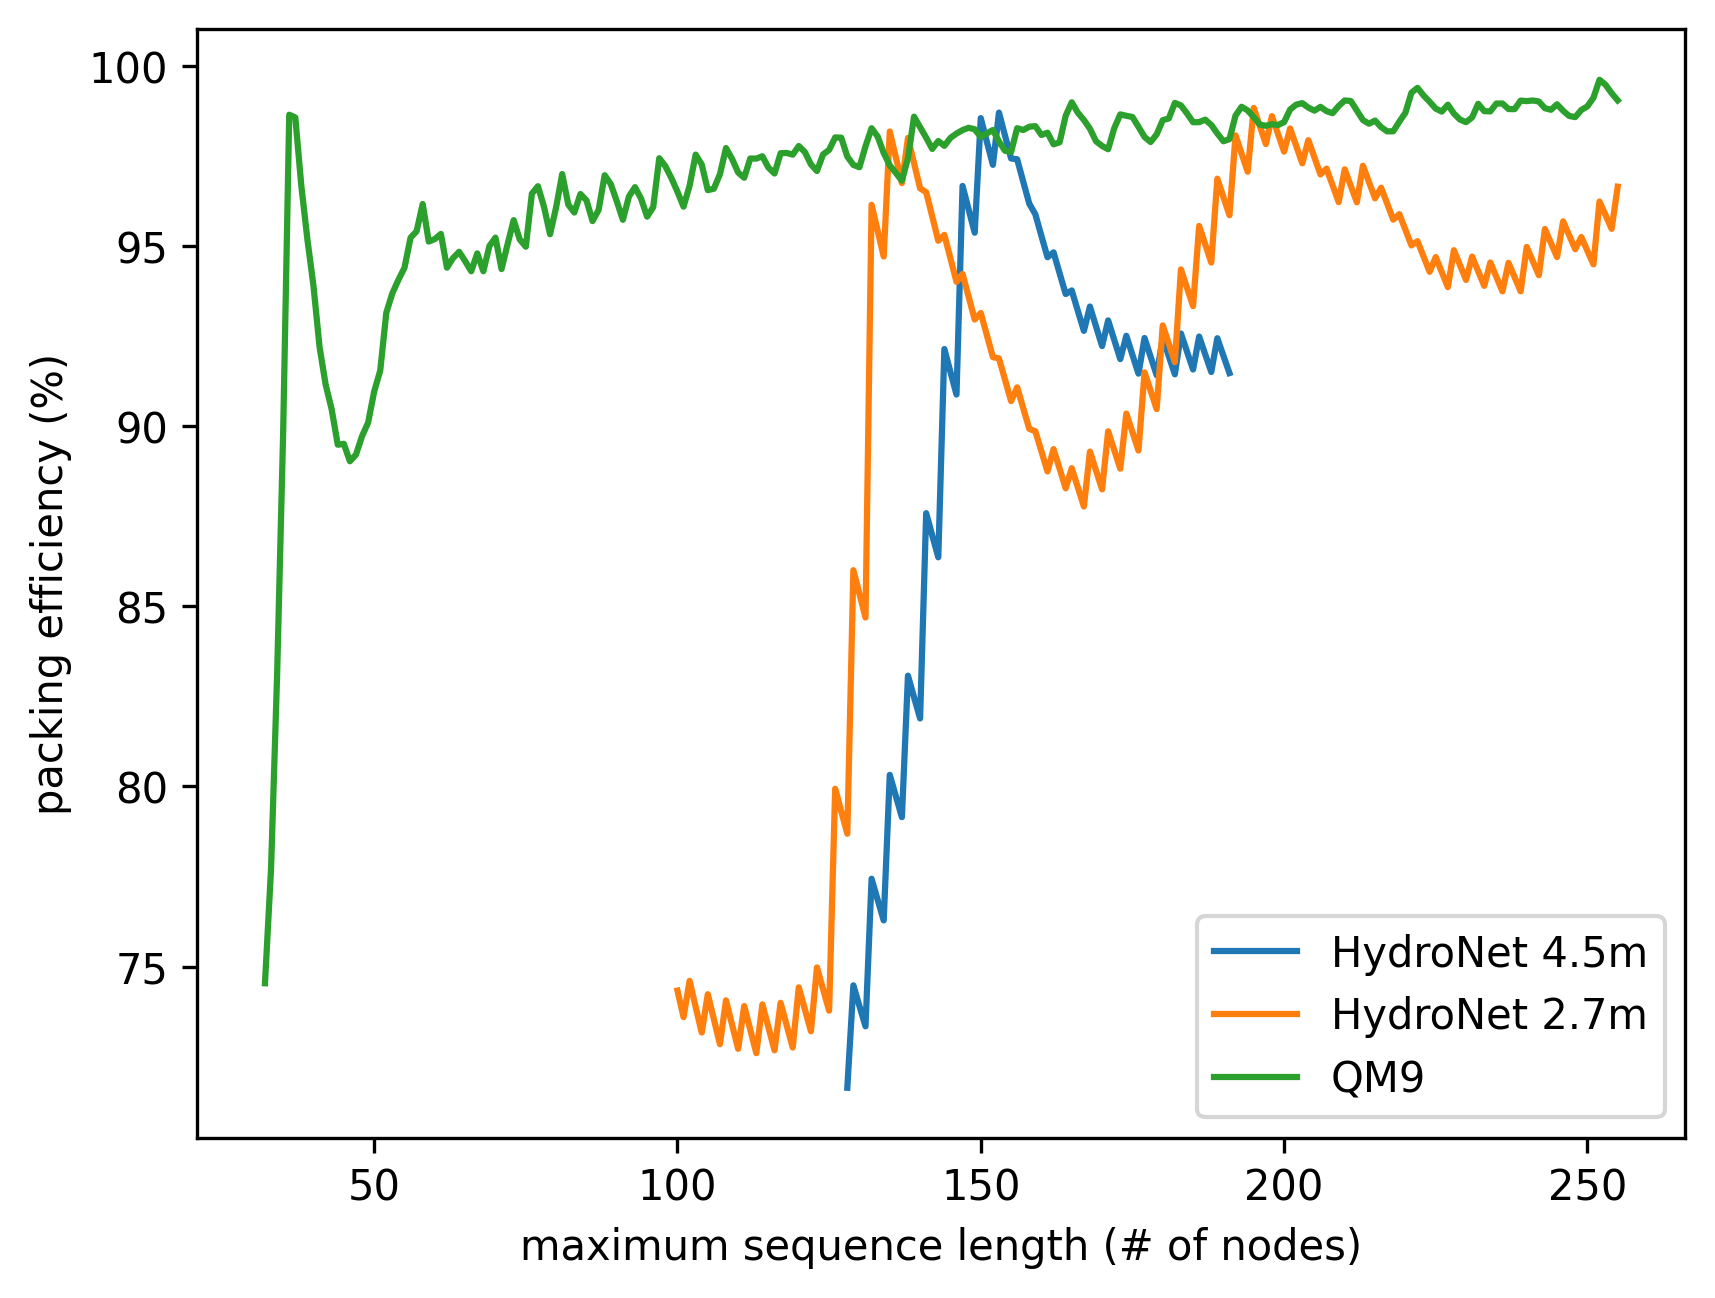

In [38]:
files = ["packing_4.5m.npz", "packing_2.7m.npz", "packing_qm9.npz"]
plt.figure(dpi=300)
for f in files:
    with np.load(f) as npzfile:
        plt.plot(npzfile["seq_length"], npzfile["efficiency"])

plt.xlabel("maximum sequence length (# of nodes)")
plt.ylabel("packing efficiency (%)")
plt.legend(["HydroNet 4.5m", "HydroNet 2.7m", "QM9"])

## Node degree histogram for full HydroNet dataset

In [ ]:
cutoff = 6.0
max_num_nodes = 28


def precompute_edges(data):
    data.edge_index = radius_graph(
        data.pos, r=cutoff, max_num_neighbors=max_num_nodes
    ).to(torch.int32)
    return data


dataset = HydroNet("./../data/hydronet_packed", transform=precompute_edges)
len(dataset)

In [ ]:
loader = DataLoader(
    dataset,
    batch_size=2048,
    num_workers=32,
    prefetch_factor=16,
    drop_last=False,
    persistent_workers=True,
)

In [ ]:
degree_histogram = torch.zeros(100, dtype=torch.long)

for batch in tqdm(loader):
    d = degree(batch.edge_index[1].long(), batch.num_nodes, torch.long)
    degree_histogram.scatter_add_(dim=0, index=d, src=torch.ones_like(d))

In [ ]:
hist_nz = degree_histogram.nonzero()
min_degree = int(hist_nz.min())
max_degree = int(hist_nz.max())
degree_histogram = degree_histogram[0 : max_degree + 1]

degree_range = torch.arange(degree_histogram.numel())
mean_degree = torch.sum(degree_range * degree_histogram) / degree_histogram.sum()
mean_degree = float(mean_degree)

plt.bar(degree_range.numpy(), degree_histogram.numpy())
plt.xlabel("Node degree")
plt.ylabel("Counts")
plt.title(f"Histogram of node degree in HydroNet dataset with cutoff={6.0}")
plt.text(60, 1e7, f"min: {min_degree}\nmax: {max_degree}\nmean: {mean_degree:.1f}")
plt.show()